# Exploratory Data Analysis Portfolio: Titanic - Machine Learning from Disaster

## Summary and Objectives
The **primary objective** of this analysis is to perform a rigorous exploratory data analysis (EDA) on the Titanic dataset to identify the socio-economic and demographic features that statistically influenced survival rates. By interrogating the relationships between passenger attributes—specifically Sex, Age, Socio-economic Class (Pclass), and Fare—this study aims to isolate the key drivers of survival to inform future predictive modeling.

This project goes beyond basic correlation by utilizing feature engineering to extract passenger titles and ship deck levels, and implementing a multi-layered imputation strategy to ensure data integrity.

## Hypotheses
This analysis is structured around testing the following three hypotheses:

1. **Gender and Age Advocacy:** Based on historical "Women and Children First" protocols, female passengers and minors (captured via the "Master" title and Age < 18) will exhibit significantly higher survival probabilities compared to adult males.

2. **Socio-Economic Stratification:** Survival rates will show a strong positive correlation with ticket class (Pclass) and ticket price (Fare), suggesting that proximity to lifeboats and social status influenced evacuation priority.

3. **Family Coordination Dynamics**: The impact of family size on survival is non-linear; solo travelers and very large families will face lower survival rates than small, coordinated family units (2–4 members).

## Imports

In [1440]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

dataset = pd.read_csv("train.csv")
print(f"This dataset has {dataset.shape[0]} rows(people) and {dataset.shape[1]} columns(attributes)")

This dataset has 891 rows(people) and 12 columns(attributes)


## Data Cleaning

### Missing Data

In [1441]:
print(dataset.isnull().sum())
"""
Out of 891 entries:

Age is missing 177 entries
Cabin is missing 687 entries
Embarked is missing 2 entries
"""

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


'\nOut of 891 entries:\n\nAge is missing 177 entries\nCabin is missing 687 entries\nEmbarked is missing 2 entries\n'

### Relating Ages to Pclass

Pclass 1
Mean = 38.233440860215055
Median = 37.0

Pclass 2
Mean = 29.87763005780347
Median = 29.0

Pclass 3
Mean = 25.14061971830986
Median = 24.0


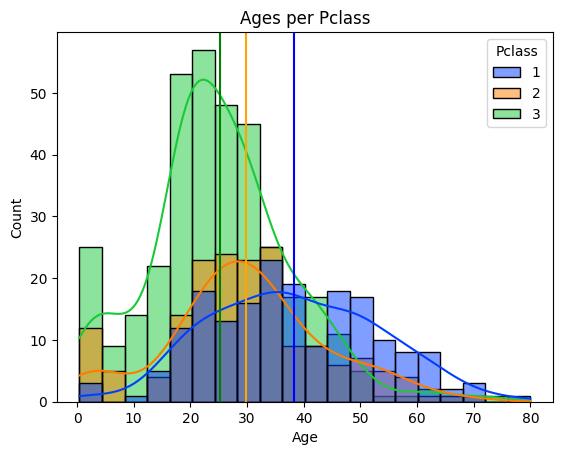

In [1442]:
# Distribution of ages per Pclass
sns.histplot(
    data=dataset,
    kde=True,
    hue="Pclass",
    x="Age",
    palette="bright"
)

# Printing means and medians of ages per Pclass
p1 = dataset[dataset["Pclass"] == 1]["Age"]
p2 = dataset[dataset["Pclass"] == 2]["Age"]
p3 = dataset[dataset["Pclass"] == 3]["Age"]

print(f"Pclass 1\nMean = {p1.mean()}\nMedian = {p1.median()}\n")
print(f"Pclass 2\nMean = {p2.mean()}\nMedian = {p2.median()}\n")
print(f"Pclass 3\nMean = {p3.mean()}\nMedian = {p3.median()}")

# Adding lines for the medians
plt.axvline(x=p1.mean(), color="blue")
plt.axvline(x=p2.mean(), color="orange")
plt.axvline(x=p3.mean(), color="green")

plt.title("Ages per Pclass")
plt.show()

The age distribution across socio-economic classes reveals a clear classification: passengers in Pclass 1 are significantly older than those in lower classes. Specifically, the median age decreases from 37 in Pclass 1 to 29 in Pclass 2, and 24 in Pclass 3, a spread of 8 and 13 years respectively. This validates the use of domain-specific imputation, ensuring that we don't 'blur' the age distributions of different social strata. Within each class, the central tendencies (mean and median) are nearly identical, suggesting a relatively symmetric distribution within these sub-groups. This lack of significant skewness justifies the use of class-specific medians for missing value imputation.

### Relating Age to Title(Mr, Mrs, Miss, etc.)

Mr
Mean = 32.368090452261306
Median = 30.0

Mrs
Mean = 35.788990825688074
Median = 35.0

Miss
Mean = 21.845637583892618
Median = 21.0

Master
Mean = 4.574166666666667
Median = 3.5

Other
Mean = 45.54545454545455
Median = 48.5


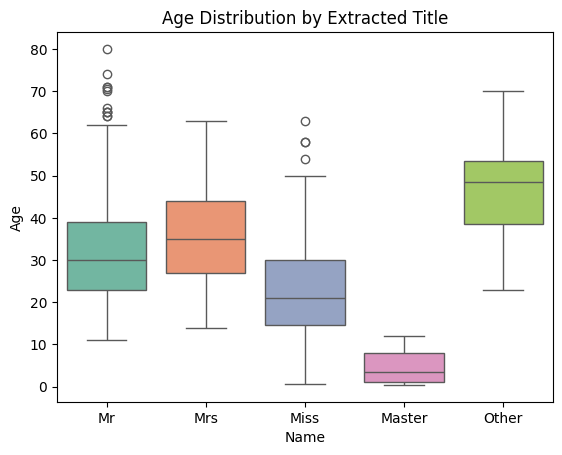

In [1443]:
# Replace names with titles (Mr, Mrs, etc.)
dataset["Name"] = dataset["Name"].str.extract(r', ([A-Za-z ]+)\.', expand=False)

# Simplify the titles
dataset['Name'] = dataset['Name'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona', 'the Countess'], 'Other')
dataset['Name'] = dataset['Name'].replace('Mlle', 'Miss')
dataset['Name'] = dataset['Name'].replace('Ms', 'Miss')
dataset['Name'] = dataset['Name'].replace('Mme', 'Mrs')

sns.boxplot(data=dataset, x='Name', y='Age', hue='Name', palette='Set2', legend=False)

# Get mean and median from ages by title
mr = dataset[dataset["Name"] == "Mr"]["Age"]
mrs = dataset[dataset["Name"] == "Mrs"]["Age"]
miss = dataset[dataset["Name"] == "Miss"]["Age"]
master = dataset[dataset["Name"] == "Master"]["Age"]
other = dataset[dataset["Name"] == "Other"]["Age"]

print(f"Mr\nMean = {mr.mean()}\nMedian = {mr.median()}\n")
print(f"Mrs\nMean = {mrs.mean()}\nMedian = {mrs.median()}\n")
print(f"Miss\nMean = {miss.mean()}\nMedian = {miss.median()}\n")
print(f"Master\nMean = {master.mean()}\nMedian = {master.median()}\n")
print(f"Other\nMean = {other.mean()}\nMedian = {other.median()}")

plt.title("Age Distribution by Extracted Title")
plt.show()

The age distributions for 'Mr' and 'Mrs' are relatively homogeneous, with similar central tendencies and interquartile ranges. In contrast, The 'Miss' demographic exhibits significant right-skewness, capturing a range of children and younger unmarried women. This confirms that titles are a more precise proxy for age than class alone. 'Master' emerged as a distinct demographic group, consistently identifying male children. The 'Other' category exhibited high variance, representing a broad spectrum of ages among specialized titles.

### Adjust Family Metric

In [1444]:
# Changing SibSp and Parch to just 1 column called family size
dataset["FamilySize"] = dataset["SibSp"] + dataset["Parch"] + 1

dataset = dataset.drop(columns=["SibSp", "Parch"])

### Filling Missing Data (Age, Cabin, Embarked)

I utilized a multi-layered imputation strategy. For 'Age', I used grouped medians based on Pclass and Title to preserve demographic nuances. For the 'Cabin' feature, due to the high percentage of missingness, I performed feature extraction to isolate the 'Deck' and categorized missing values as 'Unknown'. This transformed a messy, sparse column into a categorical feature that may correlate with survival priority.

In [1445]:
# Filling missing ages with the median of their Pclass and Title group
dataset['Age'] = dataset['Age'].fillna(dataset.groupby(['Pclass', 'Name'])['Age'].transform('median'))

# Generalize cabin to 1st letter deck
dataset['Deck'] = dataset['Cabin'].str.get(0)
dataset['Deck'] = dataset['Deck'].fillna('U') # Unknowns get a U (Unknown)
dataset = dataset.drop(columns=['Cabin']) # Drop Cabin column

# Find the most common port
mode_port = dataset['Embarked'].mode()[0]
dataset['Embarked'] = dataset['Embarked'].fillna(mode_port)

# No more missing data
print(dataset.isnull().sum())

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
Ticket         0
Fare           0
Embarked       0
FamilySize     0
Deck           0
dtype: int64


## Survival Analysis

### Family Size

Text(0.5, 1.0, 'Survival Rate based on Family Size')

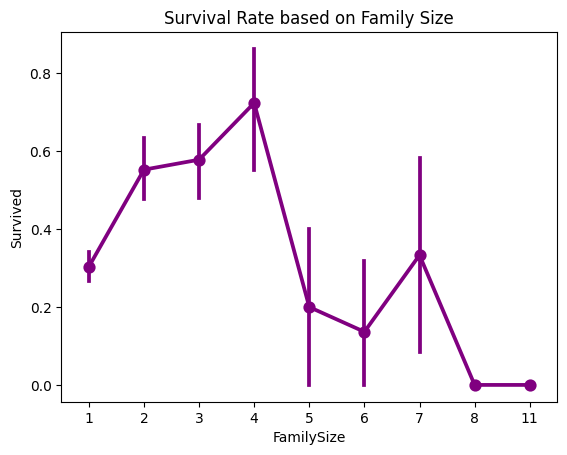

In [1446]:
# Percent of family sizes that survied
sns.pointplot(
    data=dataset,
    x="FamilySize",
    y="Survived",
    color="purple"
)

plt.title("Survival Rate based on Family Size")

### Fare vs Survival

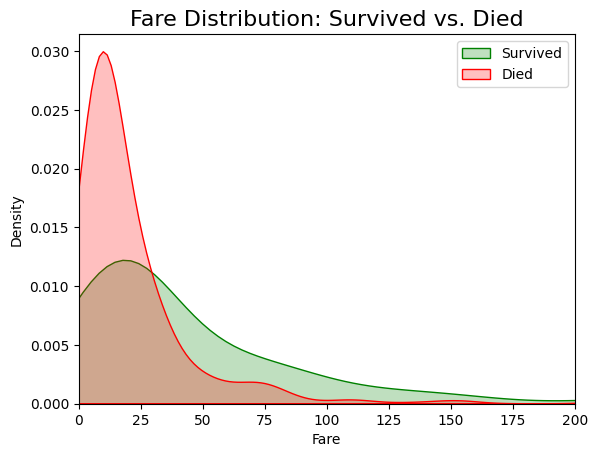

In [1447]:
sns.kdeplot(
    data=dataset[dataset['Survived'] == 1]['Fare'],
    fill=True,
    label='Survived',
    color='green'
)

sns.kdeplot(
    data=dataset[dataset['Survived'] == 0]['Fare'],
    fill=True,
    label='Died',
    color='red'
)

# Since some fares are huge, we limit the x-axis to see the detail
plt.xlim(0, 200) 
plt.title("Fare Distribution: Survived vs. Died", fontsize=16)
plt.legend()
plt.show()

### Embarked - Port of Origin vs Pclass

S Survival Rate = 34%
S Fare = 27

Q Survival Rate = 39%
S Fare = 13

C Survival Rate = 55%
S Fare = 60



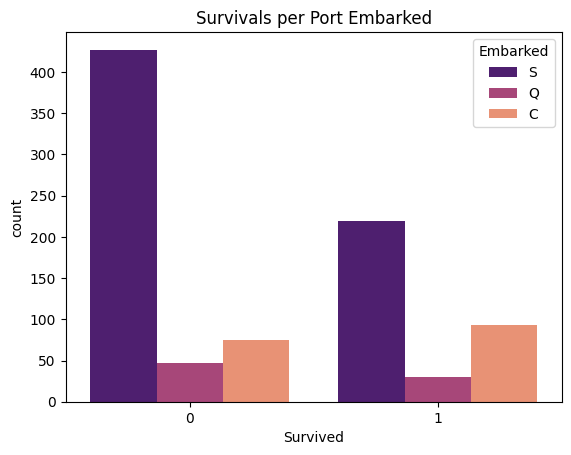

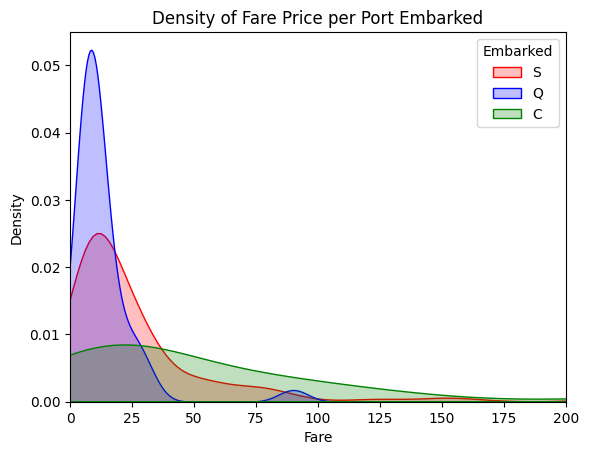

In [1448]:
# Distribution of ages per Pclass

print(f"S Survival Rate = {dataset[dataset["Embarked"] == "S"]["Survived"].mean() * 100:.0f}%")
print(f"S Fare = {dataset[dataset["Embarked"] == "S"]["Fare"].mean():.0f}")
print()

print(f"Q Survival Rate = {dataset[dataset["Embarked"] == "Q"]["Survived"].mean() * 100:.0f}%")
print(f"S Fare = {dataset[dataset["Embarked"] == "Q"]["Fare"].mean():.0f}")
print()

print(f"C Survival Rate = {dataset[dataset["Embarked"] == "C"]["Survived"].mean() * 100:.0f}%")
print(f"S Fare = {dataset[dataset["Embarked"] == "C"]["Fare"].mean():.0f}")
print()

sns.countplot(
    data=dataset,
    hue="Embarked",
    x="Survived",
    palette="magma"
)
plt.title("Survivals per Port Embarked")
plt.show()

sns.kdeplot(
    data=dataset[dataset['Embarked'] == "S"]['Fare'],
    fill=True,
    label='S',
    color='red'
)
sns.kdeplot(
    data=dataset[dataset['Embarked'] == "Q"]['Fare'],
    fill=True,
    label='Q',
    color='blue'
)
sns.kdeplot(
    data=dataset[dataset['Embarked'] == "C"]['Fare'],
    fill=True,
    label='C',
    color='green'
)
plt.xlim(0, 200)
plt.legend(title="Embarked")
plt.title("Density of Fare Price per Port Embarked")
plt.show()

### Correlation Heatmaps

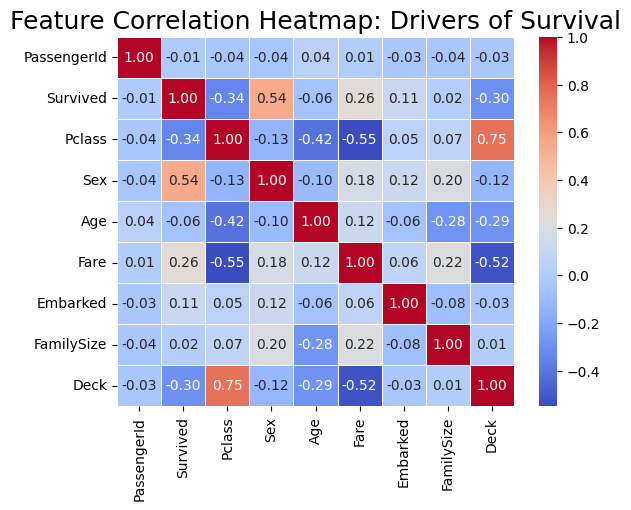

In [1449]:
# Create a copy for analysis so we don't mess up the original strings
analysis_df = dataset.copy()

# Convert Gender to binary
analysis_df['Sex'] = analysis_df['Sex'].map({'male': 0, 'female': 1})

# Convert Embarked to numbers
analysis_df['Embarked'] = analysis_df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

# Convert Deck to numbers (alphabetical order usually works)
deck_mapping = {val: i for i, val in enumerate(sorted(analysis_df['Deck'].unique()))}
analysis_df['Deck'] = analysis_df['Deck'].map(deck_mapping)

# Calculate Correlation
corr = analysis_df.corr(numeric_only=True)

# Plotting the Heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap: Drivers of Survival", fontsize=18)
plt.show()

## Final Summary and Analysis

### Introduction
This exploratory data analysis aimed to uncover the underlying patterns of survival during the Titanic disaster by examining a dataset of 891 passengers. The investigation focused on how demographic characteristics and socio-economic status dictated a passenger's likelihood of survival. To provide a high-signal analysis, significant data cleaning was performed, most notably a grouped median imputation for missing ages based on both passenger class and extracted titles. This ensured that age distributions remained historically and socially accurate. Through a combination of univariate distributions, bivariate survival plots, and multivariate correlation matrices, the following conclusions were reached regarding the initial hypotheses.

### Addressing the Hypotheses
1. **Gender and Age Advocacy:** The analysis strongly supports the "Women and Children First" hypothesis. Female passengers, regardless of class, exhibited a substantially higher survival rate than males. Feature engineering played a vital role here; by extracting the title "Master," we identified young boys who had a significantly higher survival probability than adult males (titled "Mr"). The age distribution plots showed that while "Mr" and "Mrs" followed similar adult age trends, "Miss" and "Master" skewed significantly younger, and these younger groups were prioritized during evacuation.

2. **Socio-Economic Stratification:** The data confirms a distinct survival advantage for the wealthy. Passengers in Pclass 1 had a median age of 37 and paid significantly higher fares; they also enjoyed the highest survival rates. In contrast, Pclass 3 passengers, who were generally younger (median age of 24) and paid minimal fares, suffered the highest mortality. The KDE distribution of fares clearly showed that those who paid the lowest prices were the most likely to perish. Furthermore, the extraction of the "Deck" feature suggested that passengers located on higher decks (associated with Pclass 1) had more immediate access to lifeboats than those in the lower hull.

3. **Family Coordination Dynamics:** The engineered "FamilySize" feature revealed a "sweet spot" for survival. Solo travelers had a lower probability of survival than those in small families, likely due to a lack of a support network during the crisis. However, survival rates crashed for families larger than four members. This suggests that large groups faced extreme difficulty in coordinating and staying together during the chaotic evacuation, leading to higher mortality. Therefore, the hypothesis of a non-linear relationship between family size and survival is statistically valid.

### Conclusion
In summary, survival on the Titanic was not a random occurrence but a function of institutionalized social protocols and economic standing. The most influential predictors identified were gender, passenger class, and the engineered title feature. By transforming raw strings like "Name" and "Cabin" into high-signal numerical data such as "Title," "FamilySize," and "Deck," this analysis has prepared a robust foundation for machine learning. The final correlation heatmap indicates that "Sex" and "Pclass" remain the primary drivers, but the inclusion of engineered features provides the nuance necessary for a high-accuracy predictive model.